In [1]:
import os
import string
import numpy as np
import pandas as pd
import re
import nltk
import spacy
from spacy import displacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

nlp = spacy.load('en_core_web_lg')

### Read Data

In [2]:
train_path = r'D:\Courses\4th year\2nd term\NLP\Projects\News Group\20news-bydate\20news-bydate-train'
test_path = r'D:\Courses\4th year\2nd term\NLP\Projects\News Group\20news-bydate\20news-bydate-test'
train_folders = os.listdir(train_path)
test_folders = os.listdir(test_path)
print(len(train_folders))
print(len(test_folders))

20
20


In [3]:
train_folders

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [4]:
def read_data(root_folder, sub_folders):

    data, labels = [], []
    
    for folder in sub_folders:
        path = os.path.join(root_folder, folder)
        samples = os.listdir(path)

        for sample in samples:
            sample_path = os.path.join(path, sample)
            text = open(sample_path, encoding='iso-8859-1')   # 'latin-1')
            data.append(text.read())
            labels.append(folder)
    
    return data, labels

In [5]:
train_data, train_labels = read_data(train_path, train_folders)

print(len(train_data))
print(len(train_labels))

11314
11314


In [6]:
test_data, test_labels = read_data(test_path, test_folders)

print(len(test_data))
print(len(test_labels))

7532
7532


In [7]:
print(train_labels[1200])
print('-' * 50 , end='\n\n')
print(train_data[1200])

comp.os.ms-windows.misc
--------------------------------------------------

From: loschen@binah.cc.brandeis.edu
Subject: Re: Diamond SS24X, Win 3.1, Mouse cursor
Reply-To: loschen@binah.cc.brandeis.edu
Organization: Brandeis University
Lines: 27

In article <1993Apr16.145322.16378@nlm.nih.gov>, dabl2@nlm.nih.gov (Don A.B. Lindbergh) writes:
>In article <1993Apr15.204845.24939@nlm.nih.gov> dabl2@nlm.nih.gov (Don A.B. Lindbergh) writes:
>>
>>Anybody seen mouse cursor distortion running the Diamond 1024x768x256 driver?
>>Sorry, don't know the version of the driver (no indication in the menus) but it's a recently
>>delivered Gateway system.  Am going to try the latest drivers from Diamond BBS but wondered
>>if anyone else had seen this.
>>
>
>As a followup, this is a co-worker's machine.  He has the latest 2.03 drivers.
>It only happens using the 1024x768x256 driver.  Sometimes it takes a minute
>or so for the cursor to wig out, but it eventually does in this mode.  I
>susect something is 

### Some Visualization Methods

comp.os.ms-windows.misc


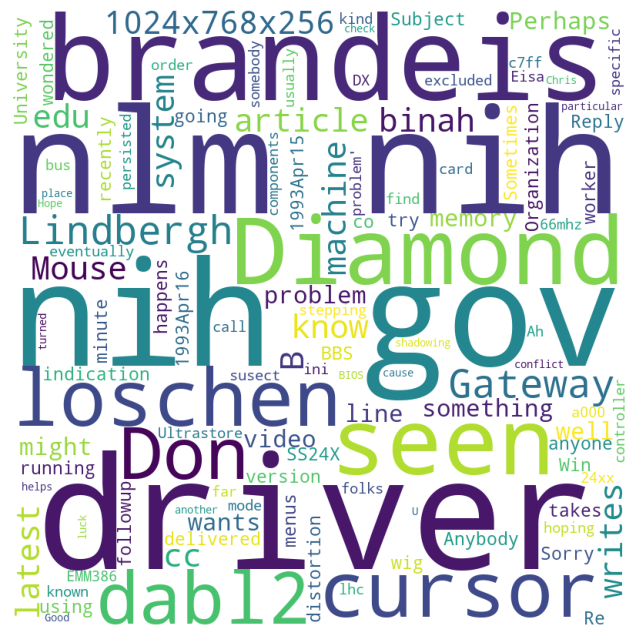

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print(train_labels[1200])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(train_data[1200])

# Display the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [9]:
print(train_labels[1200])
print('-' * 50 , end='\n\n')
displacy.render(nlp(train_data[1200]), style = "ent",jupyter = True)

comp.os.ms-windows.misc
--------------------------------------------------



In [10]:
# displacy.render(nlp(data[1200]), style = "dep",jupyter = True, options={'distance': 80,})
# displacy.render(nlp(data[1200]), style="dep", options={"compact": True, "bg": "#09a3d5",
#                                            'distance': 80,"color": "white",
#                                            "font": "Source Sans Pro"})

### Clean Header

In [11]:
def clean_header(text):
    text = re.sub(r'(From:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(Subject:[^\n]+\n)', '', text)
    text = re.sub(r'(([\sA-Za-z0-9\-]+)?[A|a]rchive-name:[^\n]+\n)', '', text)
    text = re.sub(r'(Last-modified:[^\n]+\n)', '', text)
    text = re.sub(r'(Version:[^\n]+\n)', '', text)

    return text

### Clean Text

In [12]:
re_url = re.compile(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
re_email = re.compile('(?:[a-z0-9!#$%&\'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&\'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])')                 

def clean_text(text):        
    text = text.lower()
    text = text.strip()
    text = re.sub(re_url, '', text)
    text = re.sub(re_email, '', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'(\d+)', ' ', text)
    text = re.sub(r'(\s+)', ' ', text)
    
    return text

In [13]:
for i in range(len(train_data)):
    train_data[i] = clean_text(clean_header(train_data[i]))

for i in range(len(test_data)):
    test_data[i] = clean_text(clean_header(test_data[i]))

### Tokenization

In [14]:
tokenized_train = []

for i in range(len(train_data)):
    tokenized_train.append(nltk.word_tokenize(train_data[i]))

In [15]:
tokenized_test = []

for i in range(len(test_data)):
    tokenized_test.append(nltk.word_tokenize(test_data[i]))

### Remove Stopwords

In [16]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
print(len(stop_words))
stop_words

179


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [17]:
filtered_train = []

for i in range(len(tokenized_train)):
    filtered_doc = [w for w in tokenized_train[i] if not w in stop_words]
    filtered_train.append(filtered_doc)

In [18]:
filtered_test = []

for i in range(len(tokenized_test)):
    filtered_doc = [w for w in tokenized_test[i] if not w in stop_words]
    filtered_test.append(filtered_doc)

### Stemming & Lemmatization

In [19]:
from nltk.stem import WordNetLemmatizer, PorterStemmer

lemmatizer = WordNetLemmatizer()
porterstemmer = PorterStemmer()

In [20]:
final_train = []

for i in range(len(filtered_train)):
    lemmatized_text = ' '.join(lemmatizer.lemmatize(token) for token in filtered_train[i])
    final_train.append(lemmatized_text)

# for i in range(len(filtered_train)):
#     stemmed_text = ' '.join(porterstemmer.stem(token) for token in filtered_train[i])
#     final_train.append(stemmed_text)

In [21]:
final_test = []

for i in range(len(filtered_test)):
    lemmatized_text = ' '.join(lemmatizer.lemmatize(token) for token in filtered_test[i])
    final_test.append(lemmatized_text)

# for i in range(len(filtered_test)):
#     stemmed_text = ' '.join(porterstemmer.stem(token) for token in filtered_test[i])
#     final_test.append(stemmed_text)

### Label Encoding

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train_labels)
y_test = le.fit_transform(test_labels)

### TF-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='word')
tf_idf = vectorizer.fit(final_train)

In [29]:
tf_idf

TfidfVectorizer()

In [30]:
X_train = tf_idf.transform(final_train).toarray()
X_test = tf_idf.transform(final_test).toarray()

In [31]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11314, 110779)
(7532, 110779)
(11314,)
(7532,)


### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict(X_test)
print(y_pred[:24])
print(y_test[:24])

[11  1 17 16  5  9  6 14 10 15  2  5  4  8  3 14  3  3 10  4 14 10 19 15]
[11  1 17 16  5  9  6 14 10 15  2  5  4  8  3 14  2  3 10  4 14 10 16 15]


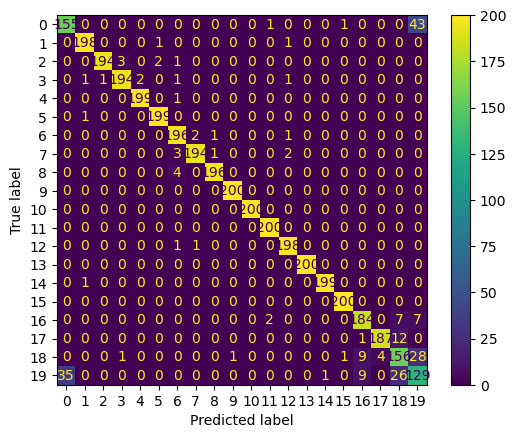

In [ ]:
cm = confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
print(f"Train Accuracy: {rf.score(X_train, y_train)*100:.3f}%")
print(f"Test Accuracy: {rf.score(X_test, y_test)*100:.3f}%")

Train Accuracy: 97.881%
Test Accuracy: 94.450%


### MLP

In [60]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(20), activation='relu', random_state=42)

mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=20, random_state=42)

In [61]:
y_pred = mlp.predict(X_test)

print(y_pred[:24])
print(y_test[:24])

[11  1 17 16  5  9  6 14 10 15  2  5  4  8  3 14  3  3 10  4 14 10 19 15]
[11  1 17 16  5  9  6 14 10 15  2  5  4  8  3 14  2  3 10  4 14 10 16 15]


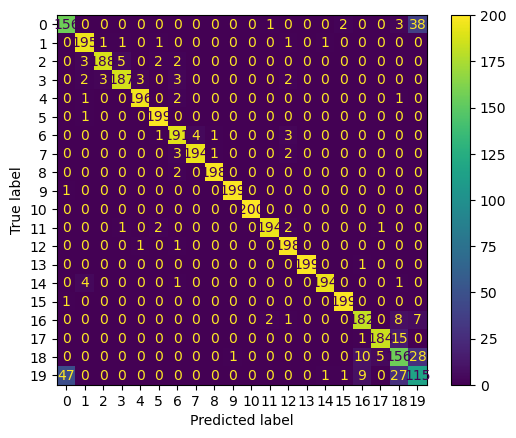

In [62]:
cm = confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

In [63]:
print(f"Train Accuracy: {mlp.score(X_train, y_train)*100:.3f}%")
print(f"Test Accuracy: {mlp.score(X_test, y_test)*100:.3f}%")

Train Accuracy: 97.881%
Test Accuracy: 93.100%


### Adaboost

In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                         algorithm="SAMME",
                        # n_estimators=100,
                         random_state=42)

adaboost.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
y_pred = adaboost.predict(X_test)

print(y_pred[:24])
print(y_test[:24])

[14  4  7  0 18  9  2  8  1 18 15 10  9 10 18  8 15  2 11 12  4 12  0 12]
[14  4  7  0 19  9  2  8  1 18 15 10  9 10 18  8 15  2 11 12  4 12  0 12]


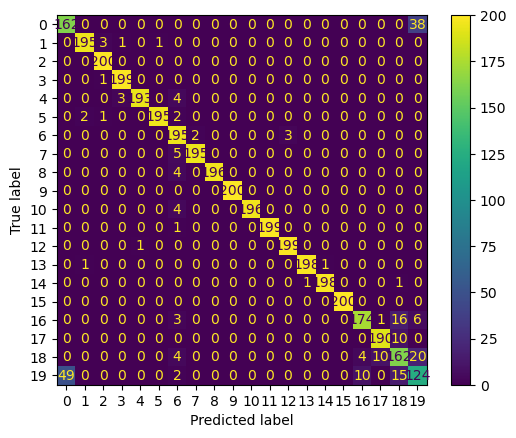

In [ ]:
cm = confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
print(f"Train Accuracy: {adaboost.score(X_train, y_train)*100:.3f}%")
print(f"Test Accuracy: {adaboost.score(X_test, y_test)*100:.3f}%")

Train Accuracy: 97.887%
Test Accuracy: 94.250%


### Decision Tree

In [ ]:
decisiontree = DecisionTreeClassifier(max_depth=5, random_state=42)
decisiontree.fit(X_train,y_train)

In [ ]:
y_pred = decisiontree.predict(X_test)

print(y_pred[:24])
print(y_test[:24])

AttributeError: 'list' object has no attribute 'take'

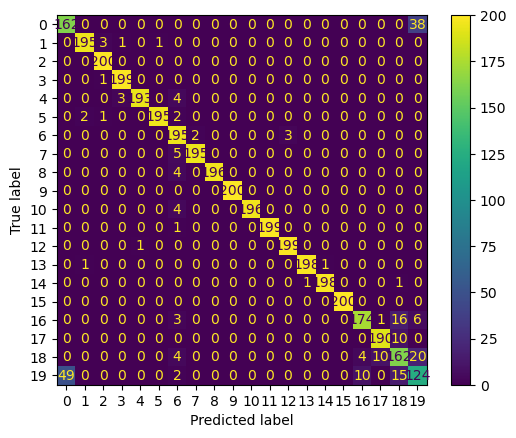

In [ ]:
cm = confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
print(f"Train Accuracy: {decisiontree.score(X_train, y_train)*100:.3f}%")
print(f"Test Accuracy: {decisiontree.score(X_test, y_test)*100:.3f}%")

Train Accuracy: 97.887%
Test Accuracy: 94.250%


### KNN

In [47]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100)

# Train the classifier
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=100)

In [48]:
y_pred = knn.predict(X_test)

print(y_pred[:24])
print(y_test[:24])

[11  1 17 16  5  9  6 14 10  0  2  5  4  8  3  1  3 10 10  3 14 10 16 15]
[11  1 17 16  5  9  6 14 10 15  2  5  4  8  3 14  2  3 10  4 14 10 16 15]


c:\Users\mohamed\anaconda3-folder\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


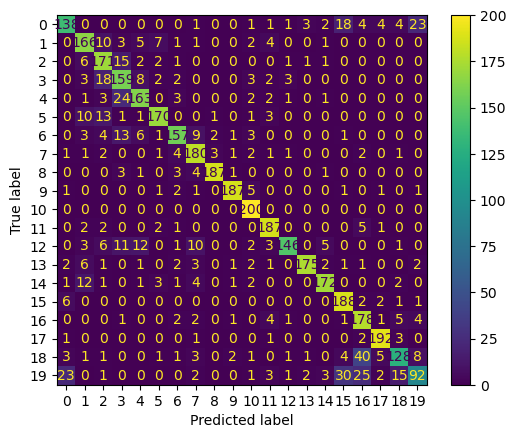

In [49]:
cm = confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

In [50]:
print(f"Train Accuracy: {knn.score(X_train, y_train)*100:.3f}%")
print(f"Test Accuracy: {knn.score(X_test, y_test)*100:.3f}%")

c:\Users\mohamed\anaconda3-folder\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Train Accuracy: 83.534%
Test Accuracy: 83.400%


c:\Users\mohamed\anaconda3-folder\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Gaussian Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [30]:
y_pred = gnb.predict(X_test)

print(y_pred[:24])
print(y_test[:24])

[11  1 17 16  1  9  6 14 10 15  2  5  4  8  3 14  3  3 10  1 14 10 19 15]
[11  1 17 16  5  9  6 14 10 15  2  5  4  8  3 14  2  3 10  4 14 10 16 15]


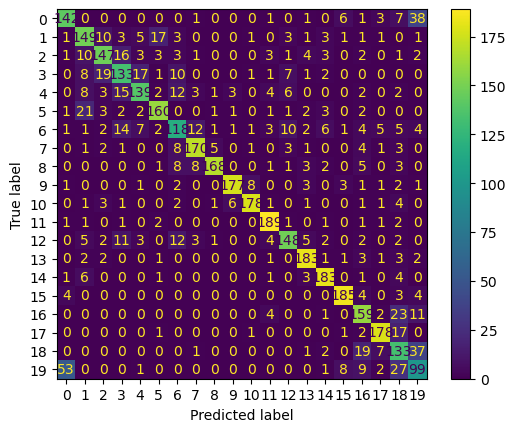

In [34]:
cm = confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

In [35]:
print(f"Train Accuracy: {gnb.score(X_train, y_train)*100:.3f}%")
print(f"Test Accuracy: {gnb.score(X_test, y_test)*100:.3f}%")

Train Accuracy: 97.006%
Test Accuracy: 78.450%
